In [19]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
from scipy.stats import norm

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils
from matplotlib import colors
from settings import colors as nc_colors
from settings import ax_label_size, tick_label_size, letter_size, lw, legend_size

In [10]:
ccycle = mplego.colors.get_default_ccycle()

In [11]:
base_path = "/storage/noise_correlations/exp10"

In [12]:
pvc11_1_path = os.path.join(base_path, 'exp10_1_pvc11_20_1000_1000.h5')
ret2_path = os.path.join(base_path, 'exp10_ret2_20_1000_1000.h5')
ecog_path = os.path.join(base_path, 'exp10_ecog_20_3000_1000.h5')

In [13]:
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ret2 = h5py.File(ret2_path, 'r')
ecog = h5py.File(ecog_path, 'r')

In [14]:
median_corrs = dict()
median_corrs_fa = dict()
median_corrs_u = dict()

pct = 50

for d in [3, 5, 10, 20]:
    indices = np.triu_indices(d, k=1)
    median_corrs[d] = []
    for ii in range(12000):
        X1, X2 = utils.get_dimstim_responses_from_h5(pvc11_1, d - 3, ii)
        cov1 = np.cov(X1.T)
        cov2 = np.cov(X2.T)
        obs = utils.cov2corr(0.5 * (cov1 + cov2))
        median_corrs[d].append(np.percentile(abs(obs[indices[0], indices[1]]), pct,
                                             interpolation='nearest'))

    opt_fa = pvc11_1['opt_fa_covs/{}'.format(d)][:]
    diag = opt_fa[:, np.arange(d), np.arange(d)]
    opt_fa = opt_fa / np.sqrt(diag[..., np.newaxis] * diag[:, np.newaxis])
    median_corrs_fa[d] = np.percentile(abs(opt_fa[:, indices[0], indices[1]]), pct,
                                       axis=1, interpolation='nearest')

    opt_u = pvc11_1['opt_u_covs/{}'.format(d)][:]
    diag = opt_u[:, np.arange(d), np.arange(d)]
    opt_u = opt_u / np.sqrt(diag[..., np.newaxis] * diag[:, np.newaxis])
    median_corrs_u[d] = np.percentile(abs(opt_u[:, indices[0], indices[1]]), pct,
                                      axis=1, interpolation='nearest')

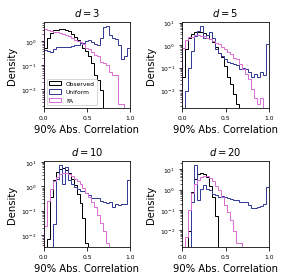

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(4, 4))

bins = np.linspace(0, 1, 30)

for ii, d in enumerate([3, 5, 10, 20]):
    ax = axes.ravel()[ii]
    label = r'Observed'
    label_u = r'Uniform'
    label_fa = r'FA'
    if ii != 0:
        label = None
        label_u = None
        label_fa = None
    ax.hist(median_corrs[d], bins=bins, histtype='step', ec=nc_colors['observed'],
            lw=lw, label=label, density=True)
    ax.hist(median_corrs_u[d], bins=bins, histtype='step', ec=nc_colors['uniform'],
            lw=lw, label=label_u, density=True)
    ax.hist(median_corrs_fa[d], bins=bins, histtype='step', ec=nc_colors['fa'],
            lw=lw, label=label_fa, density=True)
    ax.set_yscale('log')
    ax.set_xlabel(r'90% Abs. Correlation', size=ax_label_size)
    ax.set_ylabel(r'Density', size=ax_label_size)
    ax.set_xticks([0, .5, 1])
    ax.set_xlim(0, 1)
    ax.tick_params(labelsize=tick_label_size)
    ax.set_title(r'$d={}$'.format(d), size=ax_label_size)
axes[0, 0].legend(loc='lower left', fontsize=legend_size)
fig.tight_layout()
plt.savefig('supp3.pdf', dpi=300)
plt.savefig('supp3.jpg', dpi=300)